In [1]:
from data.dataset_generator import generate_dataset
from data.dataset import TripletFaceDataset
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.inception_resnet_v1 import InceptionResnetV1
import torch
from helpers.trainer import train_one_epoch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = generate_dataset("E:\\105_classes_pins_dataset")

In [13]:
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.12),
    transforms.RandomAutocontrast(p=0.13),
])

dataset = TripletFaceDataset(df, 128, transform)
dataloader = DataLoader(
    dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [14]:
def visualize_data_item(batch, sample):
    labels = ["anchor", "positive", "negative"]
    for i, label in enumerate(labels):
        plt.subplot(1, 3, i+1)
        plt.imshow(batch[i][sample].permute(1, 2, 0))
        plt.axis('off')
        plt.title(label)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


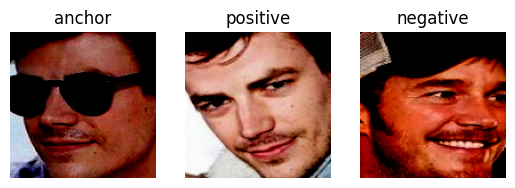

In [15]:
sample_data = next(iter(dataloader))
visualize_data_item(sample_data, 1)

In [17]:
EPOCHS = 10

embedder = InceptionResnetV1(
    pretrained='vggface2',
    device=device
)

In [18]:
anchor = embedder(sample_data[0]).cpu().detach().numpy()
positive = embedder(sample_data[1]).cpu().detach().numpy()
negative = embedder(sample_data[2]).cpu().detach().numpy()

In [19]:
import numpy as np
from scipy.spatial.distance import cosine

anchor_pos_list = []
anchor_neg_list = []

anchor_vs_pos = 0.0
anchor_vs_neg = 0.0

for image in range(32):
    anchor_vs_pos = cosine(anchor[image], positive[image])
    anchor_vs_neg = cosine(anchor[image], negative[image])
    anchor_pos_list.append(anchor_vs_pos)
    anchor_neg_list.append(anchor_vs_neg)

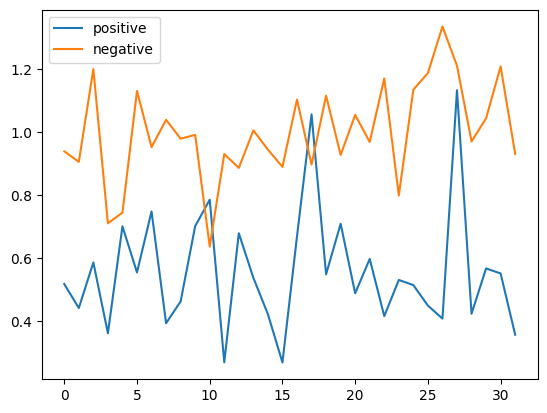

In [20]:
import matplotlib.pyplot as plt

plt.plot(anchor_pos_list)
plt.plot(anchor_neg_list)
plt.legend(["positive", "negative"])
plt.show()

In [ ]:
loss_fn = torch.nn.TripletMarginLoss(margin=0.3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1} / {EPOCHS}')
    model.train(True)
    model, pos_dist, neg_dist, avg_loss, avg_acc = train_one_epoch(model, optimizer, loss_fn, dataloader, device, 100)
    torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    print(f"Epoch loss: {avg_loss}")